<a href="https://colab.research.google.com/github/JulianaRamos2021/Previsao_compras/blob/main/Previs%C3%A3o_de_compras_Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Usando SVM para prever intenção de compra.


In [4]:
from platform import python_version
print('Versão da linguagem Python Usada neste Jupyter Notebook:', python_version())

Versão da linguagem Python Usada neste Jupyter Notebook: 3.7.15


In [5]:
#Instalar pacote Watermark. Pacote grava versões de outros pacotes neste jupyter notebook.
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 4.9 MB/s 


In [6]:
#Pacotes que precisaremos para o projeto
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn import svm
import sklearn
import matplotlib
import warnings
warnings.filterwarnings("ignore") 




In [7]:
#Versão dos pacotes usados no jupyter notebook
%reload_ext watermark
%watermark -a "Ciência dos Dados #NaPrática" --iversions

Author: Ciência dos Dados #NaPrática

seaborn   : 0.11.2
pandas    : 1.3.5
matplotlib: 3.2.2
numpy     : 1.21.6
sklearn   : 1.0.2



# BAIXANDO BASE DE DADOS

In [8]:
#Montar o Drive criando uma pasta no Google Drive criando a pasta "Previsão compras"
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/Previsao_compras"

In [9]:
#Salvando dados CSV DIRETAMENTE do site na pasta criada no Google Drive.
!wget -P "/content/drive/MyDrive/Colab Notebooks/Previsao_compras" https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv

--2022-11-20 15:31:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1072063 (1.0M) [application/x-httpd-php]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/Previsao_compras/online_shoppers_intention.csv.1’

online_shoppers_int 100%[===================>]   1.02M  3.02MB/s    in 0.3s    

2022-11-20 15:31:27 (3.02 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/Previsao_compras/online_shoppers_intention.csv.1’ saved [1072063/1072063]



In [10]:
#Criando um dataframe definido como df_original
df_original = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Previsao_compras/online_shoppers_intention.csv") 
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# CONHECENDO MAIS DETALHES SOBRE A BASE DE DADOS

**Informações do conjunto de dados:**

O conjunto de dados consiste em vetores de recursos pertencentes a 12.330 sessões.
O conjunto de dados foi formado para que cada sessão
pertenceria a um usuário diferente em um período de 1 ano para evitar
qualquer tendência a uma campanha específica, dia especial, usuário
perfil ou período.


**Informações do atributo:**

O conjunto de dados consiste em 10 atributos numéricos e 8 categóricos.
O atributo 'Revenue' pode ser usado como o rótulo da classe.

"Administrativo", "Duração Administrativa", "Informativo", "Duração Informativa", "Relacionado ao Produto" e "Duração Relacionado ao Produto" representam o número de diferentes tipos de páginas visitadas pelo visitante naquela sessão e o tempo total gasto em cada uma delas essas categorias de página. Os valores desses recursos são derivados das informações de URL das páginas visitadas pelo usuário e atualizadas em tempo real quando um usuário realiza uma ação, por exemplo, passando de uma página para outra. Os recursos "Taxa de rejeição", "Taxa de saída" e "Valor da página" representam as métricas medidas pelo "Google Analytics" para cada página do site de comércio eletrônico. O valor do recurso "Taxa de rejeição" para uma página da Web refere-se à porcentagem de visitantes que entram no site a partir dessa página e depois saem ("bounce") sem acionar nenhuma outra solicitação ao servidor analítico durante essa sessão. O valor do recurso "Taxa de saída" para uma página da Web específica é calculado como para todas as exibições de página da página, a porcentagem que foi a última na sessão. O recurso "Valor da página" representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico. O recurso "Dia Especial" indica a proximidade do horário de visita do site a um dia especial específico (por exemplo, Dia das Mães, Dia dos Namorados) em que as sessões têm maior probabilidade de serem finalizadas com transação. O valor desse atributo é determinado considerando a dinâmica do e-commerce como o tempo entre a data do pedido e a data de entrega. Por exemplo, para o dia de Valentina, esse valor assume um valor diferente de zero entre 2 de fevereiro e 12 de fevereiro, zero antes e depois dessa data, a menos que seja próximo a outro dia especial, e seu valor máximo de 1 em 8 de fevereiro. sistema, navegador, região, tipo de tráfego, tipo de visitante como visitante recorrente ou novo, um valor booleano indicando se a data da visita é final de semana e mês do ano

In [11]:
#Verificar tamanho do dataset
df_original.shape

(12330, 18)

In [12]:
#Tipo de dados
df_original.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [13]:
#Verificando valores nulos
print(df_original.isna().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [14]:
#Esse dataset não possui valores nulos, porém se houvesse para retirar uso: df_original.dropna(inplace = True)


In [15]:
#Colunas possuem valores únicos?
df_original.nunique()

Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

In [16]:
#Preparando os dados

#Criando uma cópia da minha base de dados
df = df_original.copy()

#Listas vazias para os resultados
continuous = []
categorical = []

#loop pelas colunas (vamos desconsiderar a última coluna pois é target. O comando abaixo classifica as colunas com menos de 30 diferentes tipos de dados em dados
#contínuos e acima de 30 diferentes tipos de dados em variável categorica )

for c in df.columns[:-1]:
  if df.nunique ()[c] >= 30:
      continuous.append(c)
  else:
    categorical.append(c)

In [17]:
#Verificando as variáveis contínuas
continuous

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [18]:
categorical

['Administrative',
 'Informational',
 'SpecialDay',
 'Month',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'VisitorType',
 'Weekend']

In [19]:
#Verificando as varíaveis categóricas

df[categorical].head()

,Administrative,Informational,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0,0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0,0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0,0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0,0,0.0,Feb,3,3,1,4,Returning_Visitor,True


# Visualização gráfica dos dados

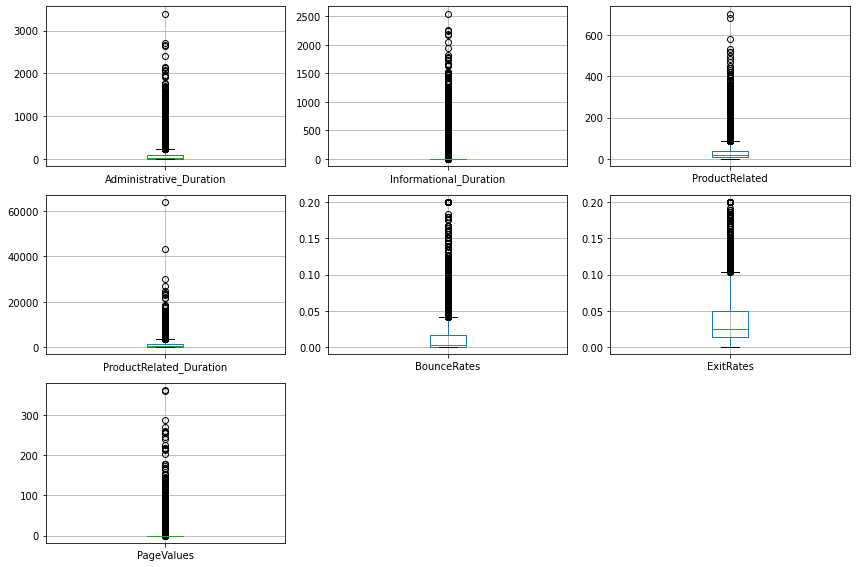

In [20]:
#Variável contínua (Imediatamente percebo muitos outliers, precisa de tratamento)

#Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

#Loop pelas variáveis contínuas
for i, col in enumerate(continuous):
  plt.subplot(3, 3, i + 1);
  df.boxplot(col);
  plt.tight_layout()

plt.savefig('boxplot1.png')

In [21]:
# Transformação de log nas variáveis contínuas
# Utilizamos transformações para podermos comparar dados com grandezas diferentes e também conseguir uma relação entre os dados de maneira mais justa. 
# Em caso de dúvidas ver explicação completa em : http://rstudio-pubs-static.s3.amazonaws.com/289147_99e32d5403f942339c3fe05414ac62fd.html

df[continuous] = np.log1p(1 + df[continuous])

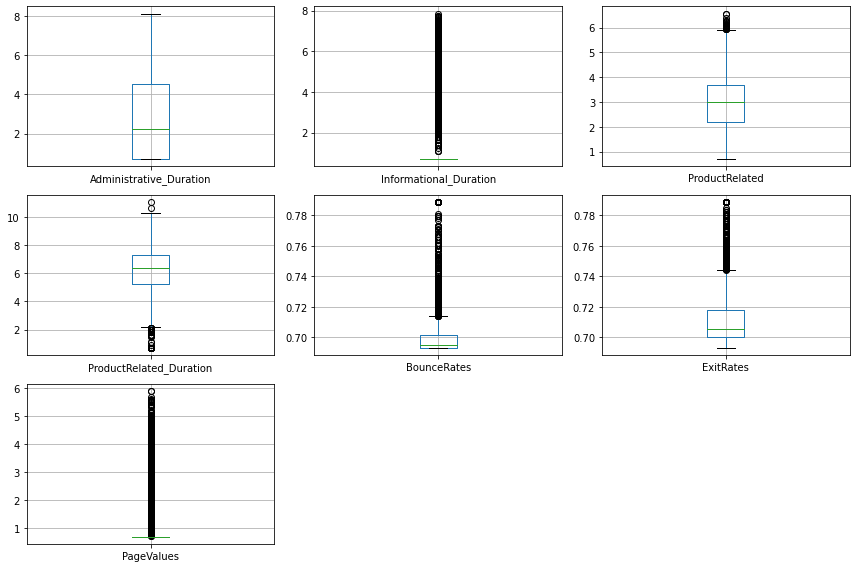

In [22]:
#Plot das variáveis contínuas

#Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

#Loop pelas variáveis contínuas
for i, col in enumerate(continuous):
  plt.subplot(3, 3, i + 1);
  df.boxplot(col);
  plt.tight_layout()

plt.savefig('boxplot2.png')
